In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #the model will use the gpu for faster performance if available


In [101]:
torch.cuda.is_available()

False


Feature Extraction (conv layer + pooling):

So, first, the image is fed to the 1st conv layer, which means it applies convolution operator between 2 matrices, 1 is the image and the other is the filter/kernel (usually it applies more than 1 kernels)
The kernel picks out specific features (depending on the values in the kernel matrix) of the image and results it in a new meatrix.

Secondly, we apply pooling, which reduces the size of the matrix (image) while retaining the features (for better computations), more specifically, max pooling, is appying a kernel that scans each region and picks out the highest pixel value in that region

Thirdly, we go to the second conv layer and max pooling and repeat the same process but  with more kernels
We then move to 

The Classifier (fully connected layer):

which behaves like the normal feed forward neural network

In [102]:

class CNN(nn.Module):
    def __init__(self, numKernels = 8, numInputChannels = 1):
        super(CNN, self).__init__()

        self.numKernels = numKernels #number of kernels to apply
        self.numInputChannels = numInputChannels #1 means the dataset is grayscale which has 1 channel
        self.kernelSize = 3

        self.convLayer1 = nn.Conv2d(self.numInputChannels, self.numKernels, self.kernelSize, stride=1, padding=1)
        self.convLayer2 = nn.Conv2d(self.numKernels * self.numInputChannels, self.numKernels * 2, self.kernelSize, stride=1, padding=1)
        self.pooling = nn.MaxPool2d(2, 2) #kernel size and stride is 2 (2*2 matrix that scans the image and moves with step(stride)=2)
        self.fc1 = nn.Linear(7*7*(self.numKernels * 2), 128) #if the input image is 28*28 then the size of it (or the feature maps to be exact) is 28/4, since we applied pooling of size 2 twice which quartered the size so, the first layer of nodes have 7*7 * the number of channels of the output of the last conv layer
        # self.fc2 = nn.Linear(128, 128) 
        self.fcOut =  nn.Linear(128, 10) #we have 10 classes

    def forward(self, x):
        x = self.convLayer1(x)
        x = F.relu(x) #applying ReLU introduces non-linearity
        x = self.pooling(x) 

        x = self.convLayer2(x)
        x = F.relu(x) #applying ReLU introduces non-linearity
        x = self.pooling(x) 

        xflat = x.view(-1, 7*7*(self.numKernels * 2)) #faltening the matrix to feed into the neurons

        xflat = self.fc1(xflat)
        xflat = F.relu(xflat) #applying ReLU introduces non-linearity
        # xflat = self.fc2(xflat)
        # xflat = F.relu(xflat)
        
        output = self.fcOut(xflat)

        return output


In convolution layers, normally, kernels/filters outputs image with shape <= original input shape, but with kernel_size=3*3, stride=1, padding=1, the output size will always be equal to that of original, also, thats why, the number of total pixels that enter the first fc layer depends only on the original size and pooling ((28/2)/2) and the number of filters (channels) applied at last conv layer

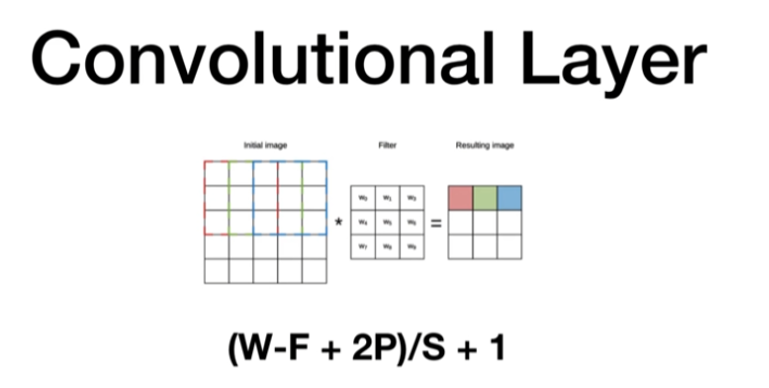

In [103]:

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
epochs = 10 #increasing epochs from 5 to 10 increased accuracy from ~85% to ~87% 
batch_size = 4
learning_rate = 0.001


In [104]:

#loading the dataset
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [105]:

print(len(train_dataset.train_data))
print(len(train_dataset.train_data[0]))
print(len(train_dataset.train_data[0][0]))

print(train_dataset.train_labels)
print(len(train_dataset.train_labels))

print(len(test_dataset.test_data))
print(len(test_dataset.test_data[0]))
print(len(test_dataset.test_data[0][0]))

60000
28
28
tensor([9, 0, 0,  ..., 3, 0, 5])
60000
10000
28
28


In [106]:
model = CNN(16).to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [107]:

print("Begin training...")

for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad() #resets the gradients to 0
        loss.backward() #computes the gradients
        optimizer.step() #updates all the parametrs (weights, biases, etc) based on the previous computed losses

        
    print (f"Epoch {epoch+1}, Loss: {loss.item()}")

print("Training Done")

Begin training...


Epoch 1, Loss: 0.3371741771697998
Epoch 2, Loss: 0.24825319647789001
Epoch 3, Loss: 0.17695359885692596
Epoch 4, Loss: 0.1330028772354126
Epoch 5, Loss: 0.09837540239095688
Epoch 6, Loss: 0.08124995231628418
Epoch 7, Loss: 0.06742816418409348
Epoch 8, Loss: 0.05459029972553253
Epoch 9, Loss: 0.04810207337141037
Epoch 10, Loss: 0.0376552976667881
Training Done


In [108]:
print("Begin testing...")

total_num=0
correct_num=0 #total number of correctly predicited outputs/classes
eachClass = [0 for i in range(10)] #list to hold correct prediction for each class, initializing 10 elements, each by 0
eachClassTotal = [0 for i in range(10)] #list to hold the total entries of the class (to calculate the percentage)

for images, labels in test_loader:
        images = images.to(device) #moves data to the gpu if available
        labels = labels.to(device)
        outputs = model(images) #these are raw values so we'll apply soft max
        _, predicted = torch.max(outputs, 1)
        # print(f"Predicted: {predicted[0].item()}, True Label: {labels[0].item()}")
        if (predicted[0].item()==labels[0].item()): #if the predicted value=label (true value)
                correct_num+=1
                eachClass[predicted[0].item()]+=1

        eachClassTotal[labels[0].item()]+=1
        total_num+=1

print("Testing Done")

print(f"\nAccuracy of model: {100*(correct_num/total_num)}%\n")
for i in range (10):
        print(f"Accuracy for class {classes[i]}: {100*(eachClass[i]/eachClassTotal[i])}%")

Begin testing...
Testing Done

Accuracy of model: 87.92%

Accuracy for class T-shirt/top: 87.6%
Accuracy for class Trouser: 96.55172413793103%
Accuracy for class Pullover: 77.55905511811024%
Accuracy for class Dress: 91.12903225806451%
Accuracy for class Coat: 81.41592920353983%
Accuracy for class Sandal: 98.01587301587301%
Accuracy for class Shirt: 62.2568093385214%
Accuracy for class Sneaker: 93.92712550607287%
Accuracy for class Bag: 96.2655601659751%
Accuracy for class Ankle boot: 94.31818181818183%


Resources that helped me:

https://www.youtube.com/watch?v=pj9-rr1wDhM

https://www.youtube.com/watch?v=pDdP0TFzsoQ&t=75s

https://www.kaggle.com/datasets/zalando-research/fashionmnist/data
